# MULTI-ARMED BANDIT

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
np.random.seed(4)

## Plot functions

In [4]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def generate_plot(r, ba, q, choose_egreedy, par, best_action=0):
    str_legend = ['{}, {}={}'.format('UCB' if not choose_egreedy else 'e-greedy', 'c' if not choose_egreedy else 'delta', p) for p in par]

    conf_1 = {'title': 'Average reward', 'xlabel': 'steps', 'ylabel': 'avg reward'}
    conf_2 = {'title': 'Percentage optimal actions', 'xlabel': 'steps', 'ylabel': '% optimal actions'}
    conf_3 = {'title': str_legend[-1], 'xlabel': 'steps', 'ylabel': 'Q(a)'}

    fig, ax = plt.subplots(1,3, figsize=(18, 7))
    for i, (data, conf) in enumerate(zip([r, ba, q],[conf_1, conf_2, conf_3])):
        if i < 2:
            for j, d in enumerate(data):
                ax[i].plot(d)
            insert_labels(conf, ax[i])
            ax[i].legend(str_legend)
        else:
            insert_labels(conf, ax[i])
            # ax[i].xlim(0, 1.2*len(data[0]))
            for j, d in enumerate(data):
                ax[i].plot(d, marker='', color='grey' if j != best_action else 'orange',
                                         linewidth=1 if j != best_action else 4,
                                         alpha=0.6 if j != best_action else 0.7)
                ax[i].text(1.02*len(d), d[-1], 'Action #'+str(j+1) if j != best_action else 'BestAction (#'+str(j+1)+')', horizontalalignment='left', size='small',
                           color='grey' if j != best_action else 'green')
    
    ax[0].plot(np.ones(len(d))*np.max(meanA)) # Include the optimum reward in the display
    str_legend.append('Optimal Reward')
    ax[0].legend(str_legend)

## Multi-armed bandit setting

In [5]:
def setInitialState(_m = 10, _dispMeansA = 1.5, _dispStd = 0.05, _meanA = None, _bestAction = None, _stdA = None, _alpha = 0.01):
    global m
    m = _m                                  # number of actions
    global dispMeansA
    dispMeansA = _dispMeansA                        # dispersion in the values of means for every action
    global dispStd
    dispStd = _dispStd                          # dispersion in the values of variances for every action
    global meanA
    if _meanA is None:
        meanA = np.random.randn(m)*dispMeansA   # means for every action
    else:
        meanA = _meanA
    global bestAction
    if _bestAction is None:
        bestAction = np.argmax(meanA)           # index of the best action
    else:
        bestAction = _bestAction
    global stdA
    if _stdA is None:
        stdA = np.random.rand(m)*dispStd        # std deviations for every action
    else:
        stdA = _stdA
    global alpha
    alpha = _alpha                            # time constant for incremental estimation of Q in time-varying environment

setInitialState()

## Simulation setting

In [6]:
NRuns = 200                             # number of independent runs to be averaged
NSteps = 500                            # number of time steps per run

r = np.zeros((NRuns, NSteps))           # instantaneous rewards
Q = np.zeros((m, NSteps))               # average reward per action
BA = np.zeros((NRuns, NSteps))          # best action collection

Strat = 0                               # 0: e-greedy, 1: UCB

## Decision taking setting

In [7]:
if Strat:
    par = np.array([0.5, 1, 2])        # values of c UCB                       
else:
    par = np.array([0, 0.1, 1])        # values of delta e-greedy       

## Random trials for each parameter of the algorithm and for all independent runs

In [8]:
def run(num_actions: int, num_steps: int, num_runs: int, parameters: list, means: list, stdDevs: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.randn(num_actions)*0.1                         # initialization of Q
            ta = np.zeros((num_actions))                                      # times each action is selected
            for t in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:,t-1])                         # select best action
                    if np.random.rand() > min(1, num_actions*parameters[e]/t):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    ta[a] += 1
                    r[i,t] = means[a] + np.random.randn()*stdDevs[a]   # obtain the gaussian reward
                    Q[:,t] = Q[:, t-1]                              # update Q function
                    Q[a,t] += 1/ta[a] * (r[i,t] - Q[a, t])
                # UCB
                else:
                    # COMPLETE THE CODE FOR UCB HERE
                    pass # remove

                BA[i,t] += bestAction == a
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
    return avg_r, avg_ba, Q

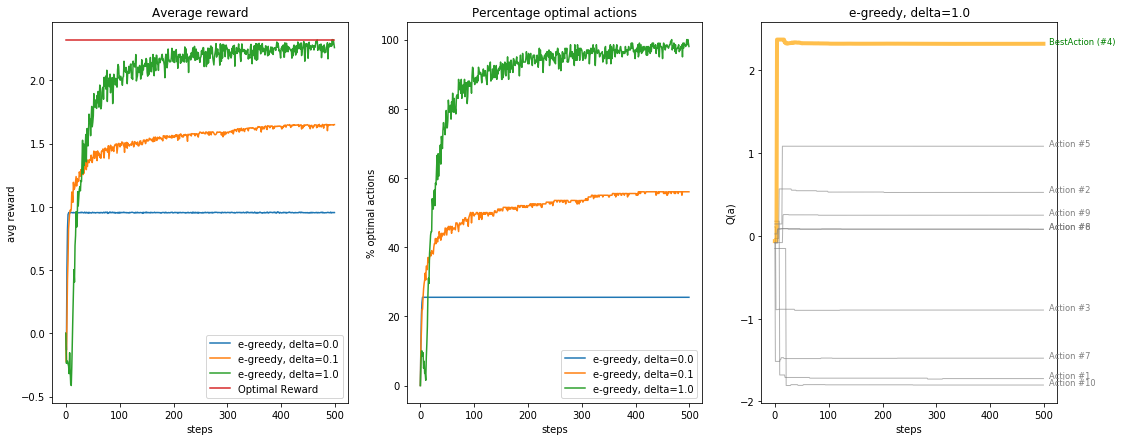

In [9]:
setInitialState()
NRuns = 200
avg_r, avg_ba, Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_ba, Q, True, par, best_action=bestAction)

## Results

### a) **For $\varepsilon$-greedy algorithm, check the reward on a single run for smaller values of the variance of the Gaussian $f(r|a)$ in example 2.1 in slides. Derive conclusions.**

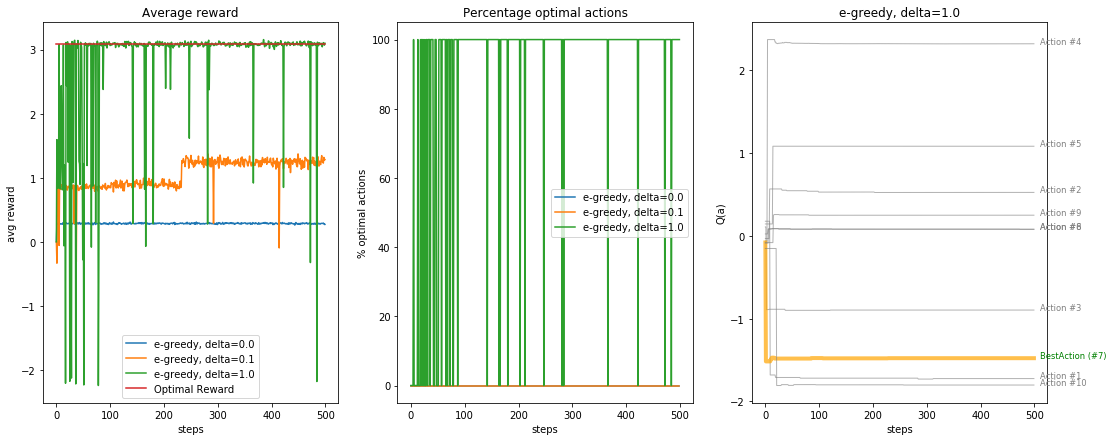

In [10]:
NRuns = 1
NSteps = 500

# Baseline: 0.05
setInitialState(_dispStd=0.05)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par, best_action=bestAction)

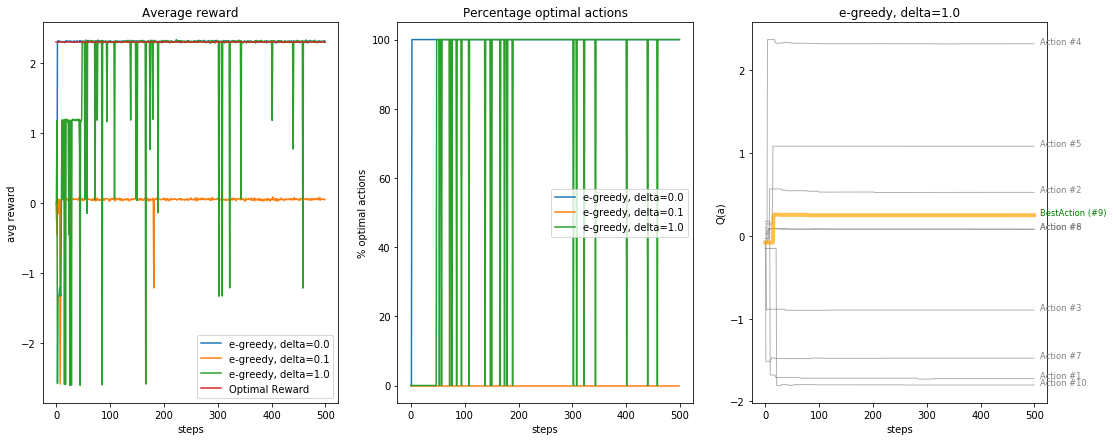

In [11]:
# Dispersion parameter is 0.4
setInitialState(_dispStd=0.01)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par, best_action=bestAction)

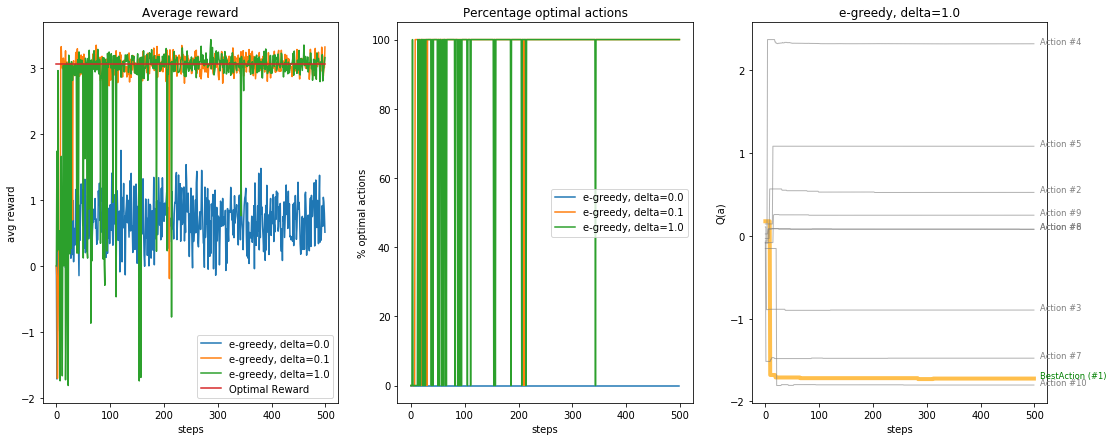

In [12]:
# Dispersion parameter is 0.4
setInitialState(_dispStd=0.4)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par, best_action=bestAction)

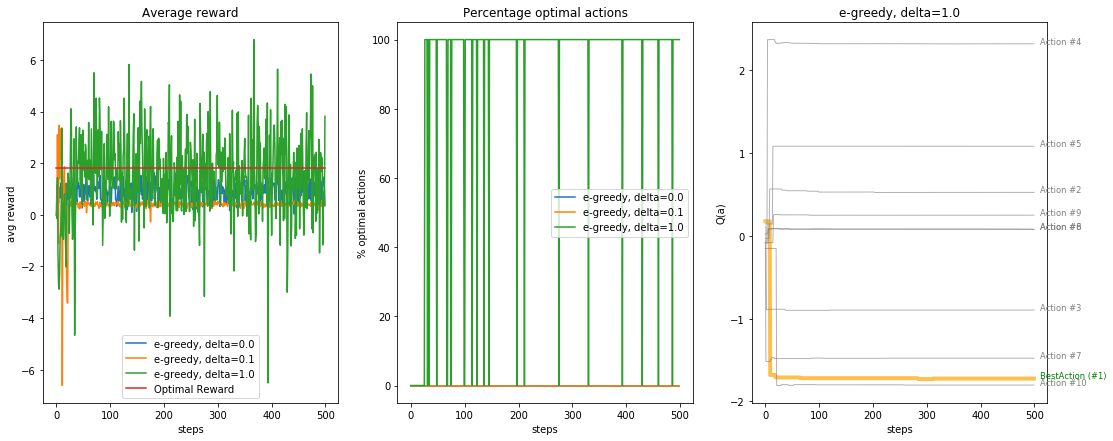

In [13]:
# Dispersion parameter is 3
setInitialState(_dispStd=3)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par)

It is clear that when the dispersion is very high, the reward at each step oscillates much more than when the reward dispersion is smaller. This makes probabilistical sense, as the optimum action at each step (the one with greater expected value) will sometimes give very skewed rewards, as well as the other actions. Also, when the obtained reward has an effect on the action-value on updating $Q$, if the action has not been very abused and when being used gives negative results, it loses a lot of value, prompting the algorithm to later choose another one that may not be the optimal one. This could discard the optimal action, or even it could prompt not ever discarding non-optimal actions. That in turn provokes that non-optimal actions may be chosen. This scenario may happen with the graphs corresponding to $\delta=0$ (blue) and high dispersion parameter. $\delta=0$ corresponds to a full greedy algorithm, so the fate of the final reward depends on the starting values of each action.

### b) **Think of a practical application that can be modeled with an $m$-armed bandit. Use a sensible $f(r\vert a)\ \forall a$ (Gaussian, binary Bernoulli, exponential, etc.) for that application. You may get inspiration from [this paper](https://arxiv.org/pdf/1904.10040v1.pdf). Assume <u>stationarity</u> over time.**

Suppose you want to rent a motorbike to get as far as possible. You have to choose an option between $m=8$ different motorbikes, each having an amount of gas in the tank which varies randomly following $f_a(r)\equiv f(r\vert a)$, with $f$ being the PDF of a beta distribution of unknown parameters $\alpha,\beta$ (this represents the fraction of the tank that is full).

### c) **Program it using the base code provided. Note that Gaussian rewards have been assumed, you'll have to do the proper modifications.**

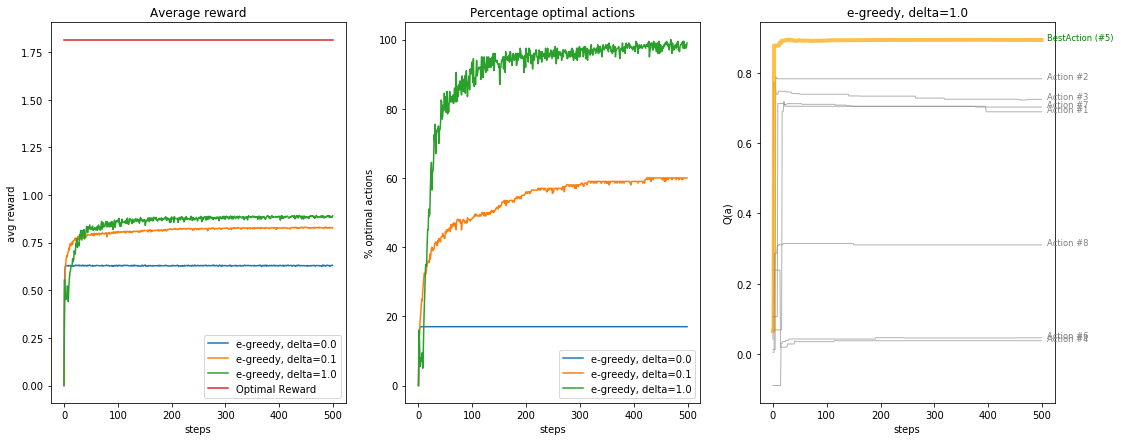

In [14]:
NRuns = 200
NSteps = 500
num_motorbikes = 8
sample_alphas = np.random.lognormal(mean=5, sigma=2, size=num_motorbikes)
sample_betas  = np.random.lognormal(mean=5, sigma=1, size=num_motorbikes)
means = [a/(a+b) for (a,b) in zip(sample_alphas, sample_betas)]
bestAction = np.argmax(means)

deltas = np.array([0.0, 0.1, 1.0])

def run_experiments(num_actions: int, num_steps: int, num_runs: int, parameters: list, alphas: list, betas: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.randn(num_actions)*0.1                         # initialization of Q
            ta = np.zeros((num_actions))                                      # times each action is selected
            for j in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:,j-1])                         # select best action
                    if np.random.rand() > min(1, num_actions*parameters[e]/j):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    ta[a] += 1
                    r[i,j] = np.random.beta(a=alphas[a], b=betas[a]) # obtain the beta rewards
                    Q[:,j] = Q[:, j-1]                              # update Q function
                    Q[a,j] += 1/ta[a] * (r[i,j] - Q[a, j])
                # UCB
                else:
                    # COMPLETE THE CODE FOR UCB HERE
                    pass # remove

                BA[i,j] += bestAction == a
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
    return avg_r, avg_ba, Q

average_reward, average_best_action, action_value = run_experiments(num_motorbikes, NSteps, NRuns, deltas, sample_alphas, sample_betas, choose_egreedy=True)
generate_plot(average_reward, average_best_action, action_value, True, deltas, best_action=bestAction)

### d) **Program the UCB technique. Check the average reward obtained in convergence for several values of the parameter. Check also the evolution of the number of correct decisions.**

I have implemented UCB for the original problem, although it is very easy and similar to implement it for our made-up experiment.

In [77]:
from math import sqrt, log

def improved_q(q: list, nta: list, num_actions: int, c: float, timestamp: int) -> list:
    res = q.copy()
    for action in range(num_actions):
        den = nta[action]
        if den == 0:
            den += 10**(-3)
        res[action] += c*sqrt(2*log(timestamp)/den)
    return res

def run(num_actions: int, num_steps: int, num_runs: int, parameters: list, means: list, stdDevs: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    bestAction = np.argmax(means)
    avg_regret = []
    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        regret = np.zeros((num_runs, num_steps))
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.normal(loc=0, scale=0.1, size=num_actions)                         # initialization of Q
            ta = np.zeros((num_actions))  
            Nta = np.zeros((num_actions))                                    # times each action is selected
            for t in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:,t-1])                         # select best action
                    if np.random.uniform(low=0, high=1) > min(1, num_actions*parameters[e]/t):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    ta[a] += 1
                    r[i,t] = means[a] + np.random.randn()*stdDevs[a]   # obtain the gaussian reward
                    Q[:,t] = Q[:, t-1]                              # update Q function
                    Q[a,t] += 1/ta[a] * (r[i,t] - Q[a, t])
                # UCB
                else:
                    Q_with_bounds = improved_q(Q[:, t-1], Nta, num_actions, parameters[e], t)
                    a = np.argmax(Q_with_bounds)
                    
                    Nta[a] += 1
                    r[i,t] = means[a] + np.random.randn()*stdDevs[a]   # obtain the gaussian reward
                    Q[:,t] = Q[:, t-1]                              # update Q function
                    Q[a,t] += 1/Nta[a] * (r[i,t] - Q[a, t])

                BA[i,t] += bestAction == a
                regret[i, t] += means[bestAction] - r[i,t]
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
        avg_regret.append(np.mean(regret.copy(), axis=0))
    return avg_r, avg_ba, Q, Nta, avg_regret

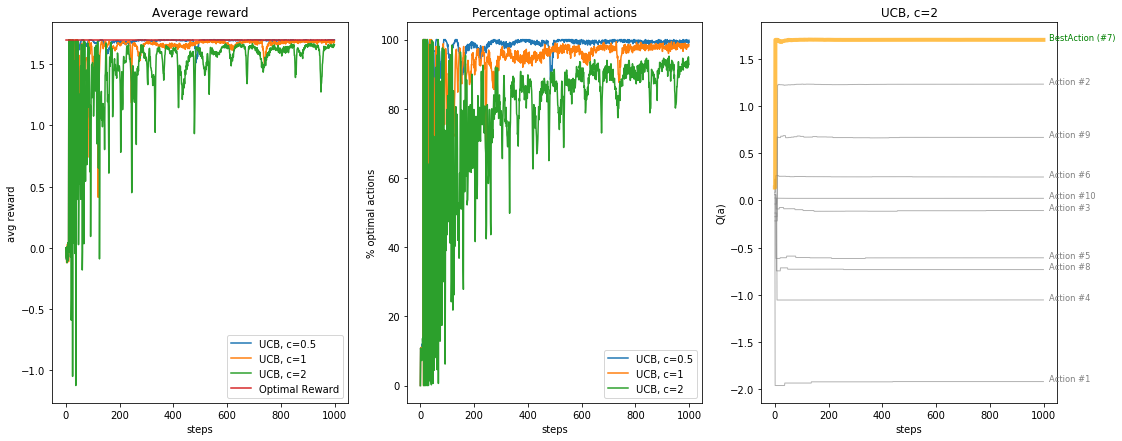

In [79]:
setInitialState()
cs = [0.5, 1, 2]
NRuns = 500
NSteps = 1000
egreedy = False
average_r, average_best_action, Q_last, Nta_last, average_regret = run(m, NSteps, NRuns, cs, meanA, stdA, choose_egreedy=egreedy)
generate_plot(average_r, average_best_action, Q_last, egreedy, cs, best_action=bestAction)

Looking through different values for $c$ in the UCB technique for the original problem, we can see that the greater the "exploration factor", the more the reward fluctuates every step, even when averaging out over 500 runs. We can even see how the percentage of optimal actions, while converging close to 100% in most repetitions of the code block, does so faster and better when $c$ is smaller, that is, when exploration is "limited". It also fluctuates a lot more when $c$ is big, because of the exploration this causes. With greater $c$, we also observe that the algorithm converges further from the optimal reward after 1000 steps, on average, which could also be caused by two actions having similar estimated values.

### e) **Plot the estimated value of $Q(a)$ for every action on a single run and comment.**

Plotting the evolution throughout all of the steps is kind of useless, as most of the exploration happens at the start of the algorithm, hence we cannot see any interesting evolution. Instead, we are going to plot the first steps of the process and see what happens when we extend the plot.

C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


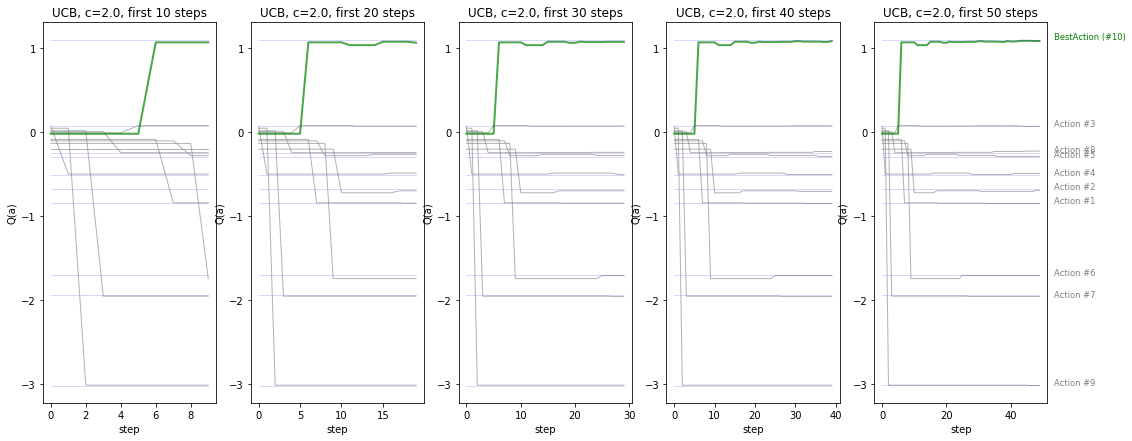

In [76]:
num_plots = 5
max_step = 50
step_length = int(max_step/num_plots)

fig, ax = plt.subplots(1, num_plots, figsize=(18, 7))

for i in range(num_plots):
    ax[i].set_title('UCB, c=2.0, first {} steps'.format((i+1)*step_length))
    ax[i].set_xlabel('step')
    ax[i].set_ylabel('Q(a)')

for i in range(len(ax)):
    mean_lines = [np.repeat(mean, (i+1)*step_length) for mean in meanA]
    for j, d in enumerate(Q_last):
        max_step_here = (i+1)*step_length
        ax[i].plot(d[0:max_step_here], marker='', color='grey' if j != bestAction else 'green',
                            linewidth=1 if j != bestAction else 2,
                            alpha=0.6 if j != bestAction else 0.7)
        ax[i].plot(mean_lines[j], marker='', color='blue', linewidth=0.5, alpha=0.3)
        if i == num_plots-1:
            ax[i].text(1.07*len(d[0:max_step_here]), d[-1], 'Action #'+str(j+1) if j != bestAction else 'BestAction (#'+str(j+1)+')',
                                horizontalalignment='left', size='small',
                                color='grey' if j != bestAction else 'green')
fig.show()

Generally, UCB identifies the optimal action pretty fast, so there is no use in extending the plot much further than the first 50-100 steps. However, the code can be changed to decide the maximum step, and the number of plots. We are always plotting the last estimated Q taken from the last run and last value of $c$ of the previous code block.

### f) **Plot the evolution of regret for $\varepsilon$-greedy and UCB algorithms and comment.**

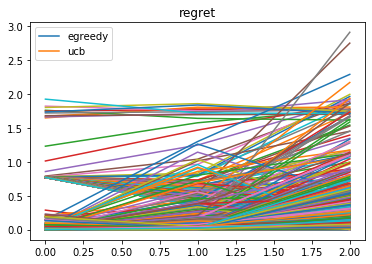

In [81]:
cs = [0.5, 1, 2]
deltas = [0, 0.1, 1.0]
NRuns = 200
NSteps = 500
egreedy = False
_, _, _, _, avg_egreedy_regret = run(m, NSteps, NRuns, deltas, meanA, stdA, choose_egreedy=True)
_, _, _, _, avg_ucb_regret = run(m, NSteps, NRuns, cs, meanA, stdA, choose_egreedy=False)
plt.figure(1)
plt.plot(avg_egreedy_regret)
plt.plot(avg_ucb_regret)
plt.legend(['egreedy', 'ucb'])
plt.title('regret')
plt.show()

### g) **Program another MAB procedure among those reviewed in the theory lectures (gradient bandit, probability matching).**

### h) **Make the environment in b) non-stationary, and include the appropriate changes to allow the algorithms track the best decisions.**

### i) **Is the capacity of exploration of UCB affected in the non-stationary case? Why? Propose a modification that performs better in these conditions.**

<BarContainer object of 20 artists>

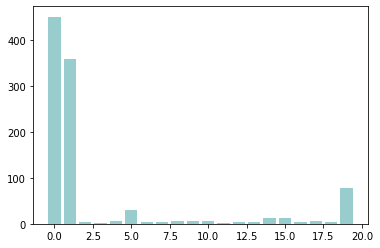

In [18]:
plt.bar(range(m), Nta_last, color='teal', alpha=0.4)